## Predicting whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so it will be discarded. The age, shape, margin, and density attributes are the features that will be used to build the model with, and "severity" is the classification we will attempt to predict based on those attributes.


Several different machine learning techniques will be applied to this data set to see which one yields the highest accuracy as measured with K-Fold cross validation (K=10):

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* Neural network

The data needs to be cleaned and normalized; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

In [144]:
import pandas as pd
import numpy as numpy
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import tree, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

## Preparing the data
Import of the data set, converting missing values (indicated as ?), setting column names.

In [145]:
col_names = ['BI_RADS', 'age', 'shape', 'margin', 'density', 'severity']
df = pd.read_csv('mammographic_masses.data.txt', na_values='?', header=None, names=col_names)
df.head()

,BI_RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


Evaluation of the data we have.

In [146]:
df.describe()

,BI_RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Creating a new dataset with dropped NaN's

In [150]:

df_dropped_na = df.dropna()

Converting pandas dataframe to numpy array (actually not) and normalizing it.

In [151]:
# Features 
features = df_dropped_na[['age', 'shape', 'margin', 'density']]
scaler = StandardScaler().fit(features)
features_scaled = scaler.transform(features)

# Labels
labels = df_dropped_na[['severity']]

## Decision Trees

Creating a single train/test split of the data.

In [152]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.20, random_state=42)

Creating a Decision Tree / Random Forest Classifier and fit it to the training data.

In [153]:
# Decision Tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

# Random Forest
clf_rand_forest = RandomForestClassifier(n_estimators=10)
clf_rand_forest = clf_rand_forest.fit(X_train, y_train) 

Measuring the accuracy of the resulting decision tree model using test data.

In [154]:
score_dec_tree = clf.score(X_test, y_test)
score_rand_forest = clf_rand_forest.score(X_test, y_test)

print('Decision tree score: ' + str(score_dec_tree))
print('Random forest score: ' + str(score_rand_forest))

Decision tree score: 0.7771084337349398
Random forest score: 0.7710843373493976


Using K-Fold cross validation to get a better measure of model's accuracy (K=10).


In [155]:
# Refit models with all data (not only on training piece)
clf_all_data = tree.DecisionTreeClassifier()
clf_all_data = clf_all_data.fit(features_scaled, labels)

# Random Forest
clf_rand_forest_all_data = RandomForestClassifier(n_estimators=10)
clf_rand_forest_all_data = clf_rand_forest_all_data.fit(features_scaled, labels) 

scores_trees_Kcrossval = cross_val_score(clf_all_data, features_scaled, labels, cv=10)
scores_rand_forest_Kcrossval = cross_val_score(clf_rand_forest_all_data, features_scaled, labels, cv=10)

print('Decision tree K-fold validation score: ' + str(scores_trees_Kcrossval.mean()))
print('Random forest K-fold validation score: ' + str(scores_rand_forest_Kcrossval.mean()))

Decision tree K-fold validation score: 0.7397590361445782
Random forest K-fold validation score: 0.755421686746988


## SVM

Using svm.SVC with rbf kernel (showed highest score)

In [156]:
clf_svm = svm.SVC(kernel='rbf')
scores_svm = cross_val_score(clf_svm, features_scaled, labels, cv=10)

print('SVM K-fold validation score: ' + str(scores_svm.mean()))

SVM K-fold validation score: 0.8012048192771084


## KNN
K-Nearest-Neighbors method. Starting with K hyperparameter as 5.

In [157]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh = neigh.fit(features_scaled, labels)

scores_KNN = cross_val_score(neigh, features_scaled, labels, cv=10)
print('KNN score: ' + str(scores_KNN.mean()))

KNN score: 0.7710843373493976


Now making an algo to choose the best K for our dataset in range from 1 to 200.

In [158]:
def choose_K(X, y):
    K = []
    for i in range(1, 200):
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh = neigh.fit(X, y)
        scores_KNN = cross_val_score(neigh, X, y, cv=10)
        K.append(scores_KNN.mean())
    return K

K_eval = choose_K(features_scaled, labels)
max_KNN_score = max(K_eval)
index_KNN_max = K_eval.index(max_KNN_score)

print('Max KNN score: {0} when K={1}'.format(max_KNN_score, index_KNN_max))

Max KNN score: 0.808433734939759 when K=85


## Naive Bayes

Multinomial Naive Bayes classifier. MinMaxScale is applied to get the features in the range MultinomialNB requires.

In [159]:
# MinMax Scale unscaled dataset first to use with NB
min_max_scaler = MinMaxScaler().fit(features)
features_min_max_scaled = min_max_scaler.transform(features)

clf_multinom_NB = MultinomialNB()
clf_multinom_NB = clf_multinom_NB.fit(features_min_max_scaled, labels)

scores_NB = cross_val_score(clf_multinom_NB, features_min_max_scaled, labels, cv=10)
print('Multinomial Naive Bayes score: ' + str(scores_NB.mean()))

Multinomial Naive Bayes score: 0.7855421686746988


## Logistic Regression

Trying Logistic Regression

In [160]:
clf_logis_regr = LogisticRegression(random_state=0, solver='lbfgs').fit(features_scaled, labels)

scores_logis_regr = cross_val_score(clf_logis_regr, features_scaled, labels, cv=10)
print('Logistic Regression score: ' + str(scores_logis_regr.mean()))

Logistic Regression score: 0.8072289156626505


## Neural Network
Keras neural network 


In [172]:
def create_nn_model():
    model = Sequential()
    #4 feature inputs (attributes/features of masses) going into an 64-unit layer 
    model.add(Dense(64, input_dim=4, kernel_initializer='normal', activation='relu'))
   
    # Another hidden layer of 32 units
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))

    # Output layer with a binary classification (bening or malignant mass)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    # Set optimizer
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# Wrap Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_nn_model, epochs=10, verbose=0)

nn_model = estimator.fit(X_train, y_train,
                    batch_size=3,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_test, y_test))

scores_NN = cross_val_score(estimator, features_scaled, labels, cv=10)
print('Neural Network score: ' + str(scores_NN.mean()))

Epoch 1/10
222/222 - 2s - loss: 0.5145 - accuracy: 0.7726 - val_loss: 0.4219 - val_accuracy: 0.8072
Epoch 2/10
222/222 - 0s - loss: 0.4881 - accuracy: 0.7907 - val_loss: 0.4098 - val_accuracy: 0.8193
Epoch 3/10
222/222 - 0s - loss: 0.4866 - accuracy: 0.7922 - val_loss: 0.4443 - val_accuracy: 0.8133
Epoch 4/10
222/222 - 0s - loss: 0.4949 - accuracy: 0.7907 - val_loss: 0.4074 - val_accuracy: 0.8253
Epoch 5/10
222/222 - 0s - loss: 0.4888 - accuracy: 0.7922 - val_loss: 0.4372 - val_accuracy: 0.8072
Epoch 6/10
222/222 - 0s - loss: 0.4900 - accuracy: 0.8027 - val_loss: 0.4091 - val_accuracy: 0.8313
Epoch 7/10
222/222 - 0s - loss: 0.4828 - accuracy: 0.7982 - val_loss: 0.4844 - val_accuracy: 0.8012
Epoch 8/10
222/222 - 0s - loss: 0.4956 - accuracy: 0.8012 - val_loss: 0.4733 - val_accuracy: 0.7952
Epoch 9/10
222/222 - 0s - loss: 0.4841 - accuracy: 0.8057 - val_loss: 0.4176 - val_accuracy: 0.8133
Epoch 10/10
222/222 - 0s - loss: 0.4873 - accuracy: 0.8057 - val_loss: 0.4833 - val_accuracy: 0.8012

## Models evaluation

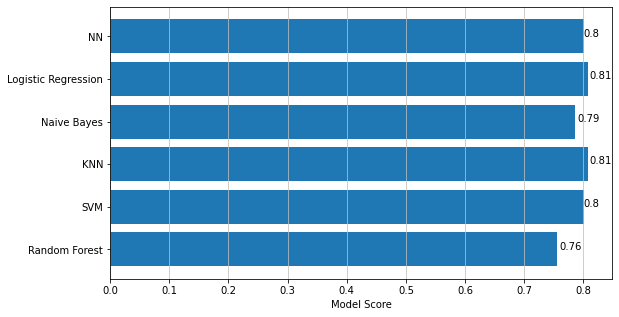

In [171]:
model_labels = ['Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'Logistic Regression', 'NN']
all_scores = [scores_rand_forest_Kcrossval.mean(), 
    scores_svm.mean(),
    max_KNN_score, scores_NB.mean(), 
    scores_logis_regr.mean(), 
    scores_NN.mean()]

scores_round = [round(num, 2) for num in all_scores]

plt.figure(figsize=(9, 5))
plt.grid(True, lw=0.75, ls='-', c='.75', axis='x')
plt.xlabel('Model Score')
plt.barh(model_labels, all_scores)

for index, value in enumerate(scores_round):
    plt.text(value, index, str(value))

## Conclusion
As we can see, most models produce more or less equal results. Logistic regression looks good due to high score and simplicity. KNN with K = 84 is just slightly better. Decision trees are the least accurate.